In [1]:
import os
import cv2
import numpy as np
import scipy
from skimage import io
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

In [2]:
input_path = "./images/"
output_path = "./output/"

if not os.path.exists(output_path):
    os.mkdir(output_path)


img = None

for image_file in os.listdir(input_path):
    img = cv2.imread(os.path.join(input_path, image_file), 0)

In [3]:
#Função para melhor visualização dos espectros
def realce_log(img):
    return np.log(1 + np.abs(img.copy()))

# Imagem de referências para os experimentos

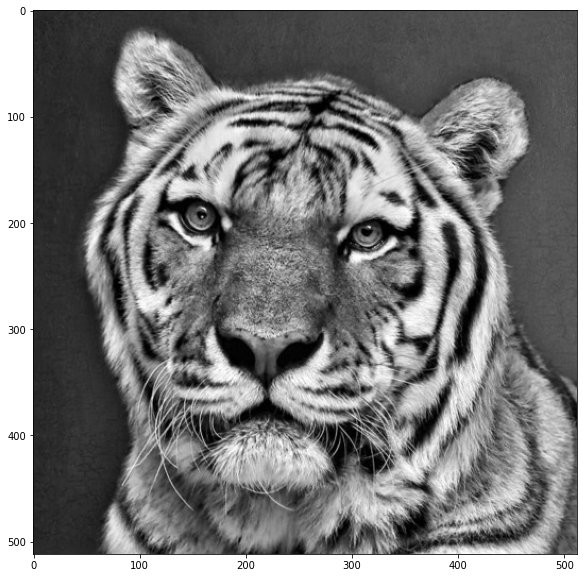

In [4]:
plt.imshow(img, cmap = 'gray')
plt.show()

## Visualização do Espectro de Fourier

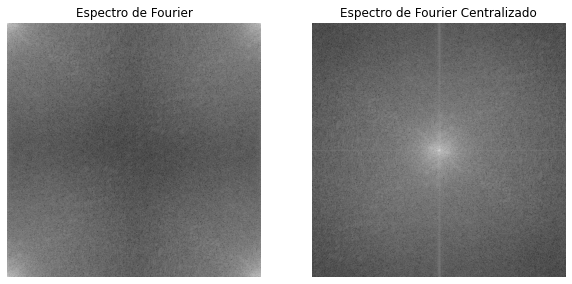

In [5]:
img_fft = np.fft.fft2(img)
img_fft_centralizada = np.fft.fftshift(img_fft)

plt.subplot(1,2,1), plt.imshow(realce_log(img_fft), cmap = 'gray'), plt.title("Espectro de Fourier")
plt.axis("off")
plt.subplot(1,2,2), plt.imshow(realce_log(img_fft_centralizada), cmap ='gray'), plt.title("Espectro de Fourier Centralizado")
plt.axis("off")
plt.show()

## Low Pass Filter

In [6]:
def low_pass_filter(image, radius = 50, plot_spectrum = False, save = False, name = "output"):
    h, w = image.shape
    if radius > h or radius > w:
        raise ValueError("Raio maior que uma das dimensões da imagem. Favor selecionar um valor adequado")
    if radius <= 0:
        raise ValueError("Apenas valores positivos para os raios são aceitos!")
    
    #Criação da máscara
    mask = np.zeros((h, w))
    cv2.circle(mask, (h//2, w//2), radius, (255, 255, 255), thickness = -1)
    mask = np.where(mask == 255, 1, 0)
    
    #Aplicação do filtro
    masked = np.multiply(image, mask)
    
    #Descentralização do dominio e aplicação da transformada inversa
    masked_descentralizado = np.fft.ifftshift(masked)
    filtered_image = np.fft.ifft2(masked_descentralizado).real

    if plot_spectrum:
        plt.figure(figsize = (10, 10))
        plt.subplot(1,2,1),plt.imshow(realce_log(masked), cmap = 'gray')
        plt.axis("off")
        plt.subplot(1,2,2),plt.imshow(realce_log(masked_descentralizado), cmap = 'gray')
        plt.axis("off")
        plt.show()
    
    plt.imshow(np.abs(filtered_image), cmap = 'gray')
    plt.axis("off")
    if save:
        plt.savefig(f"{output_path}{name}-low-{radius}.png",bbox_inches='tight', pad_inches = 0)
    plt.show()

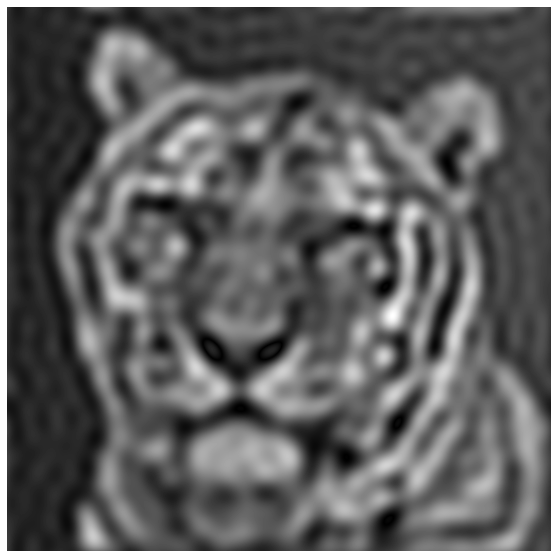

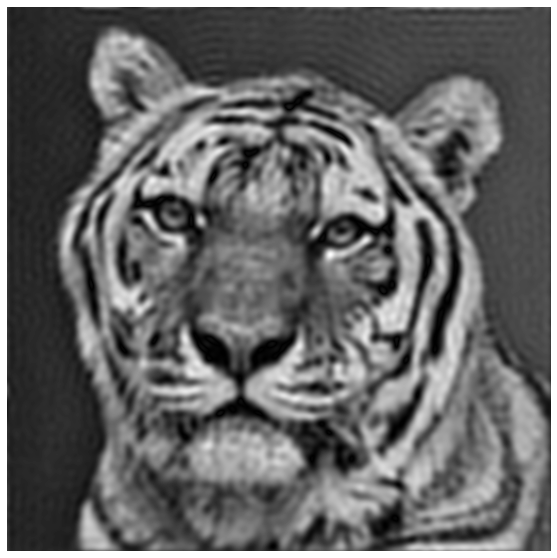

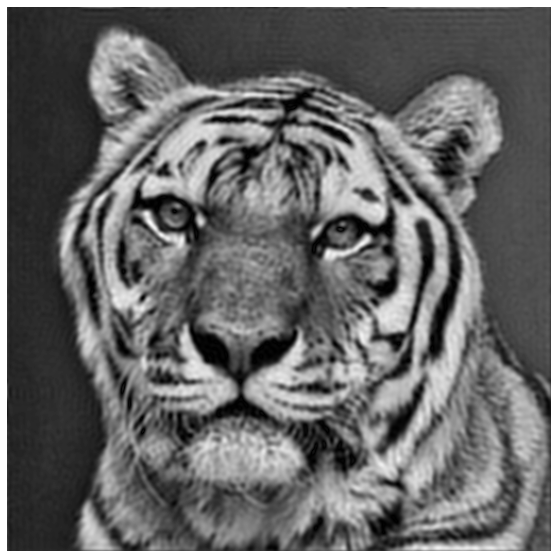

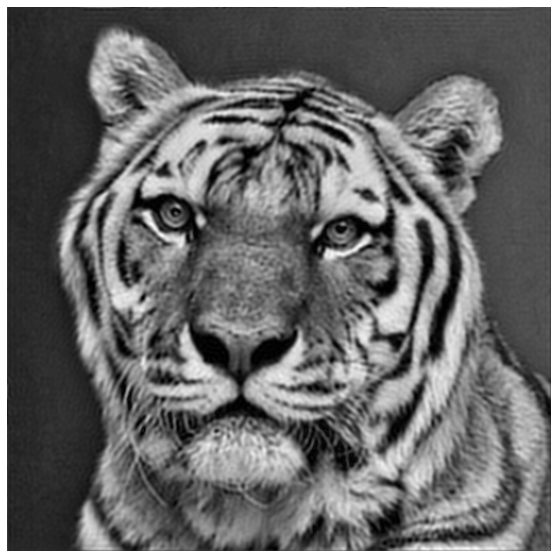

In [7]:
#Raios utilizados no relatório
raios = [20, 50, 80, 100]
for raio in raios:
    low_pass_filter(img_fft_centralizada, raio, plot_spectrum=False, save=True, name="tiger")

## High Pass Filter

In [8]:
def high_pass_filter(image, radius = 50, plot_spectrum = False, save = False, name = "output"):
    h, w = image.shape
    if radius > h or radius > w:
        raise ValueError("Raio maior que uma das dimensões da imagem. Favor selecionar um valor adequado")
    
    if radius <= 0:
        raise ValueError("Apenas valores positivos para os raios são aceitos!")

    mask = np.zeros((h, w))
    
    #Criação da mascara
    cv2.circle(mask, (h//2, w//2), radius, (255, 255, 255), thickness = -1)
    mask = np.where(mask == 255, 0, 1)
    
    #Aplicação do filtro
    masked = np.multiply(image, mask)

    #Descentralização do dominio e aplicação da transformada inversa
    masked_descentralizado = np.fft.ifftshift(masked)
    filtered_image = np.fft.ifft2(masked_descentralizado).real

    if plot_spectrum:
        plt.figure(figsize = (10, 10))
        plt.subplot(1,2,1), plt.imshow(realce_log(masked), cmap = 'gray')
        plt.axis("off")
        plt.subplot(1,2,2), plt.imshow(realce_log(masked_descentralizado), cmap = 'gray')
        plt.axis("off")
        plt.show()
    
    plt.imshow(np.abs(filtered_image), cmap = 'gray')
    plt.axis("off")
    if save:
        plt.savefig(f"{output_path}{name}-high-{radius}.png",bbox_inches='tight', pad_inches = 0)
    plt.show()

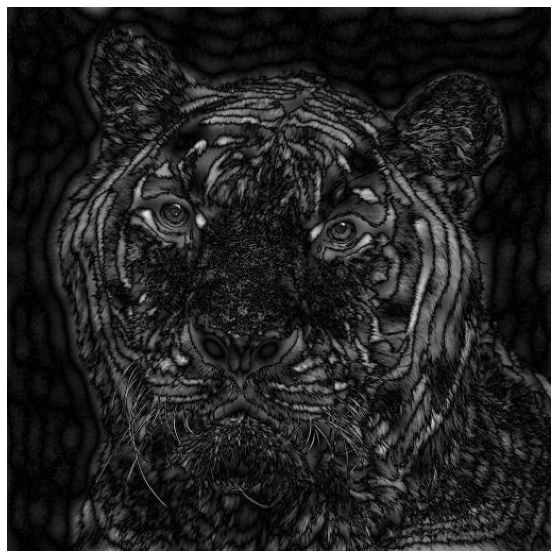

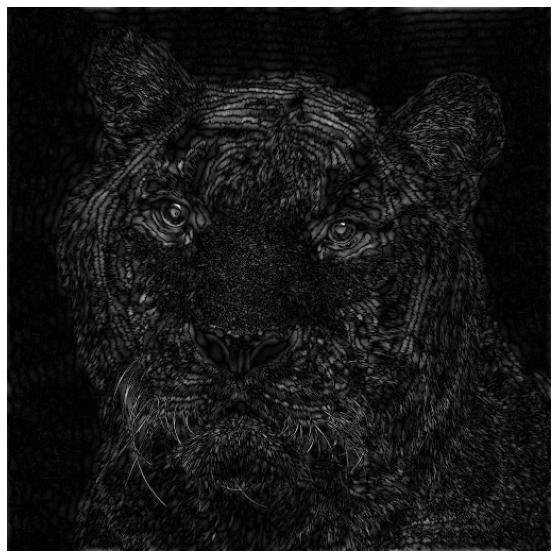

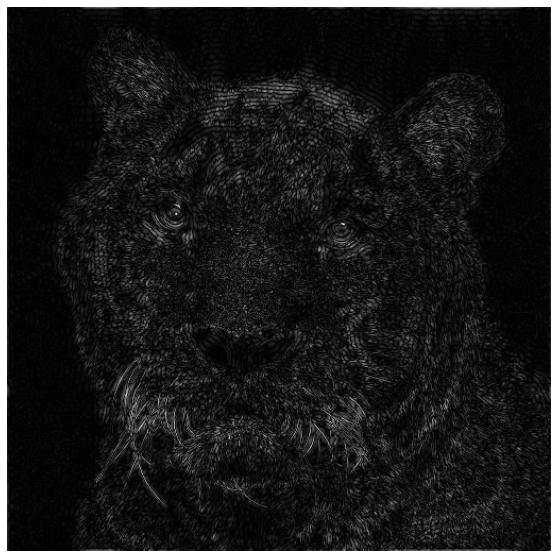

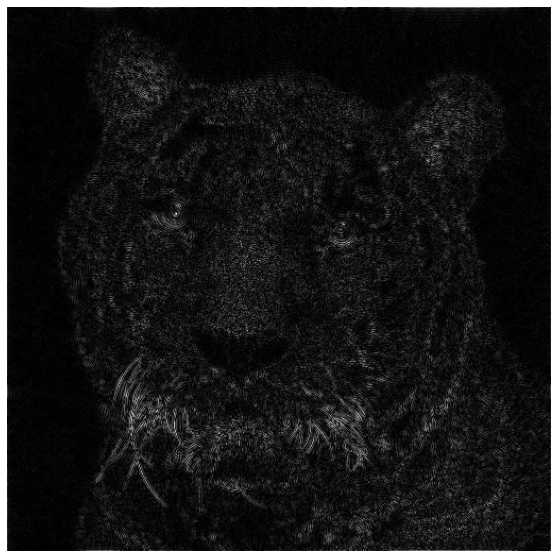

In [9]:
#Raios utilizados no relatório
raios = [15, 30, 50, 80]

for raio in raios:
    high_pass_filter(img_fft_centralizada, raio, plot_spectrum=False, save=True, name="tiger")

## Band-pass filter

In [10]:
def bandpass_filter(image, small_radius = 20, large_radius = 80, plot_spectrum = False, save = False, name = "output"):
    h, w = image.shape
    if small_radius > h or small_radius > w or large_radius > h or large_radius > h:
        raise ValueError("Raio maior que uma das dimensões da imagem. Favor selecionar um valor adequado")
    if large_radius <= small_radius:
        raise ValueError("Favor inserir um valor correto para o raio menor ou maior")
    if small_radius <= 0 or large_radius <= 0:
        raise ValueError("Apenas valores positivos para os raios são aceitos!")
    
    #mask for inner and outer circunference 
    mask_small, mask_big = np.zeros((h, w)), np.zeros((h, w))
    
    #Criação da circunferência interna
    cv2.circle(mask_small, (h//2, w//2), small_radius, (255, 255, 255), thickness = -1)
    mask_small = np.where(mask_small == 255, 1, 0)

    #Criação da circunferência externa
    cv2.circle(mask_big, (h//2, w//2), large_radius, (255, 255, 255), thickness = -1)
    mask_big = np.where(mask_big == 255, 1, 0)

    #Operação de XOR para a seleção apenas da região de interesse
    mask = mask_small ^ mask_big

    #Aplicação da máscara de passa-faixa
    masked = np.multiply(image, mask)
    
    masked_descentralizado = np.fft.ifftshift(masked)
    filtered_image = np.fft.ifft2(masked_descentralizado).real

    if plot_spectrum:
        plt.subplot(1,2,1), plt.imshow(realce_log(masked), cmap = 'gray')
        plt.axis("off")
        plt.subplot(1,2,2), plt.imshow(realce_log(masked_descentralizado), cmap = 'gray')
        plt.axis("off")
        plt.show()
    
    plt.imshow(np.abs(filtered_image), cmap = 'gray')
    plt.axis("off")
    if save:
        plt.savefig(f"{output_path}{name}-faixa-{small_radius}-{large_radius}.png",bbox_inches='tight', pad_inches = 0)
    plt.show()

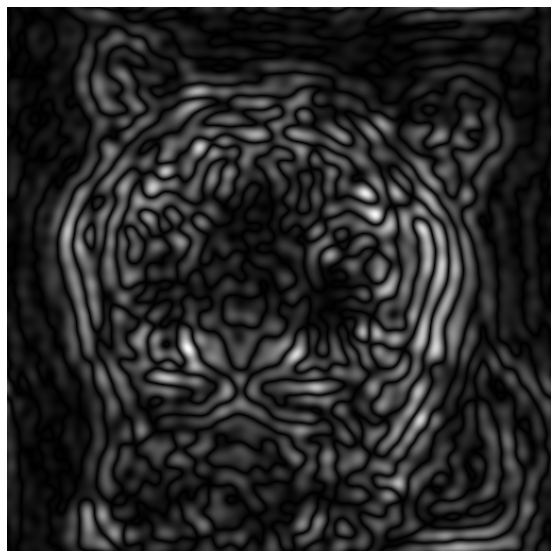

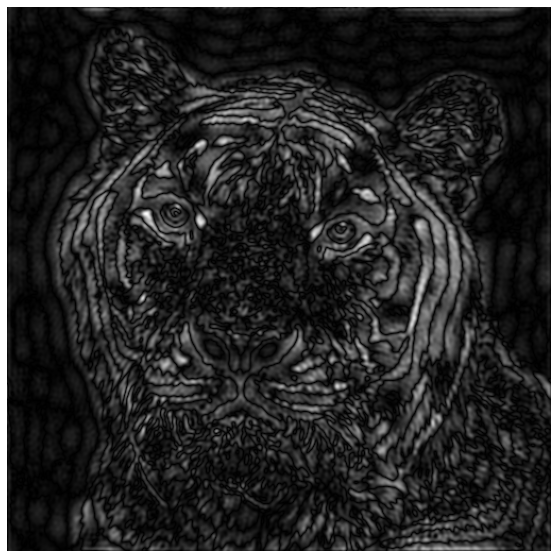

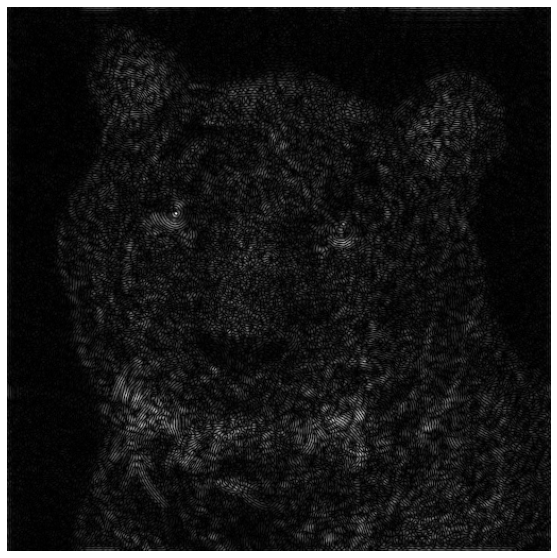

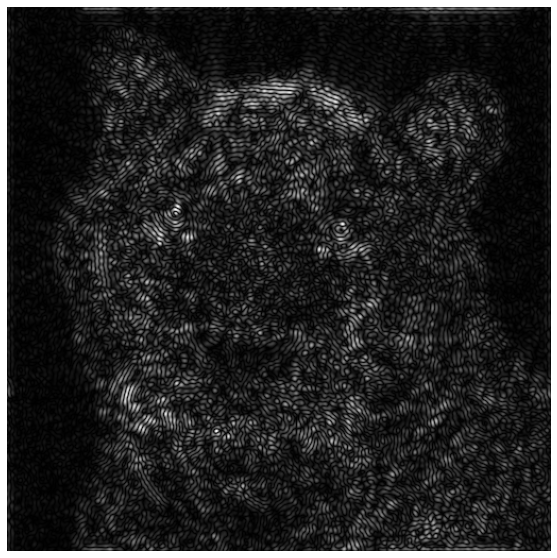

In [11]:
#Raios utilizados no relatório
raios = [(10, 30), (15, 100), (80, 150), (50, 100)]

for (ri, re) in raios:
    bandpass_filter(img_fft_centralizada, ri, re,  plot_spectrum=False, save=True, name="tiger")

## Image Compression

In [12]:
def compress_image(image, limiares, save = False, name = "output"):
    h, w = image.shape
    maximo = np.abs(image).max().real
    for k in limiares:
        if k <= 0:
            continue
        
        limiar = k*maximo
        image_copy = image.copy()
        
        #Matriz booleada com os indices a serem rejeitados
        qtd = np.abs(image_copy) <= limiar
        #Soma dos indices rejeitados
        cutted_off = qtd.sum()
        percent = 100*cutted_off/(h*w)
        
        #Imagem após a remção das frequencias abaixo do limiar selecionado        
        filtered = np.where(np.abs(image_copy) <= limiar, 0, image_copy)

        #Shift inverso no dominio de frequencia e imagem comprimida após os cortes de frequencia
        central = np.fft.ifftshift(filtered)
        compressed_image = np.abs(np.fft.ifft2(central).real)
        
        plt.figure(figsize=(7,7))
        plt.title(f"Percentagem rejeitada: {round(percent, 2)}%", fontsize = 15)
        plt.axis("off")
        plt.imshow(compressed_image, cmap = 'gray')
        if save:
            plt.savefig(f"{output_path}compress-{name}-{round(k, 6)}.png", bbox_inches='tight', pad_inches = 0)
        plt.show()
    
    return 0

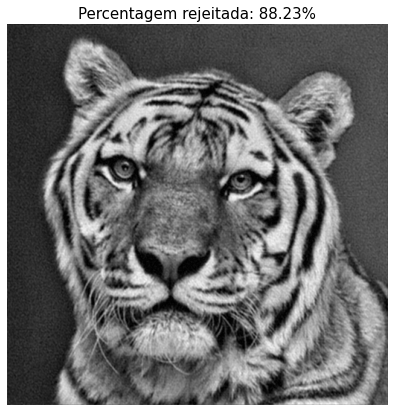

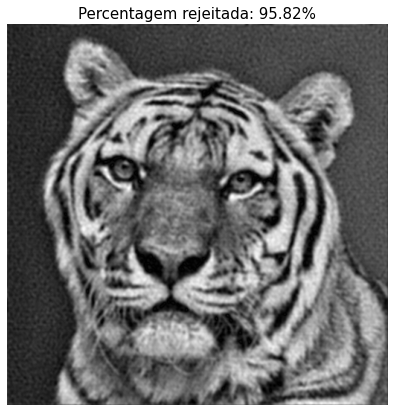

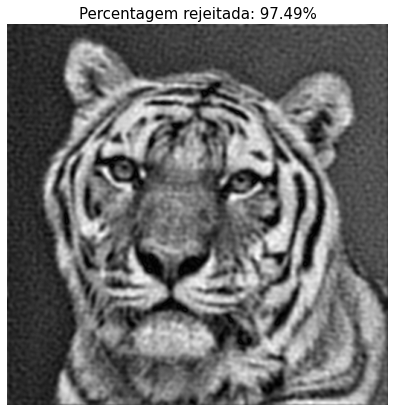

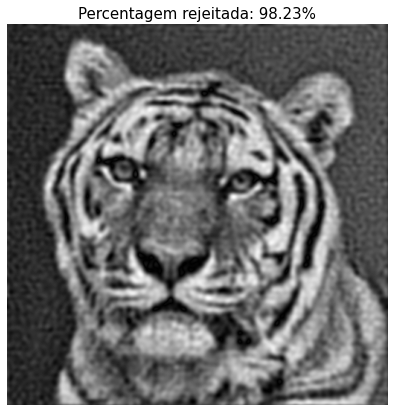

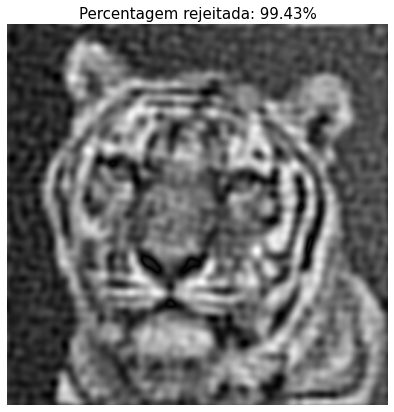

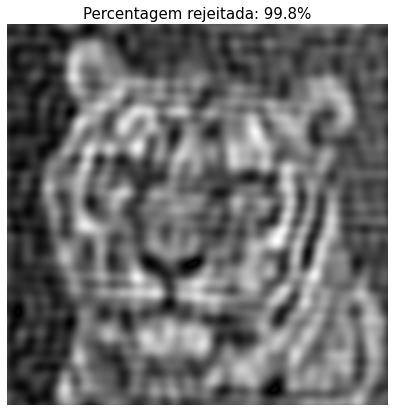

0

In [13]:
#Valores para k utilizados no relatórios
k = np.array([0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01], "float")
compress_image(img_fft_centralizada, k, save=True, name="tiger")